In [ ]:
!pip install colorama
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

np.random.seed(7)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from google.colab import drive
drive.mount('/content/drive')
#%matplotlib inline
#plt.style.use('fivethirtyeight')
df= pd.read_csv('/content/drive/MyDrive/Datasets/Traffic_Monthly/Trafik.csv', delimiter=';')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Mounted at /content/drive


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date')

,y,GT_Covid,GT_Umroh,GT_Perang Rus-Ukr,GT_PSBB
date,,,,,
2011-01-31,1092145.0,0,23,0,0
2011-02-28,989675.0,0,21,0,0
2011-03-31,1093419.0,0,25,0,0
2011-04-30,1032268.0,0,26,1,0
2011-05-31,1087500.0,0,24,0,0
...,...,...,...,...,...
2023-04-30,1084894.0,3,47,39,0
2023-05-31,1299488.0,3,62,36,0
2023-06-30,1198978.0,2,46,38,0


In [ ]:
df = pd.read_csv("../input/acea-water-prediction/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [ ]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [ ]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


Since this is a TimeSeries problem, we have to parse 'date' column

In [ ]:
from datetime import datetime, date

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">1. Data visualization 📊</p>

Features:
* **Rainfall** indicates the quantity of rain falling (mm)
* **Temperature** indicates the temperature (°C)
* **Volume** indicates the volume of water taken from the drinking water treatment plant (m 3 )
* **Hydrometry** indicates the groundwater level (m)

Target:
* **Depth to Groundwater** indicates the groundwater level (m from the ground floor)

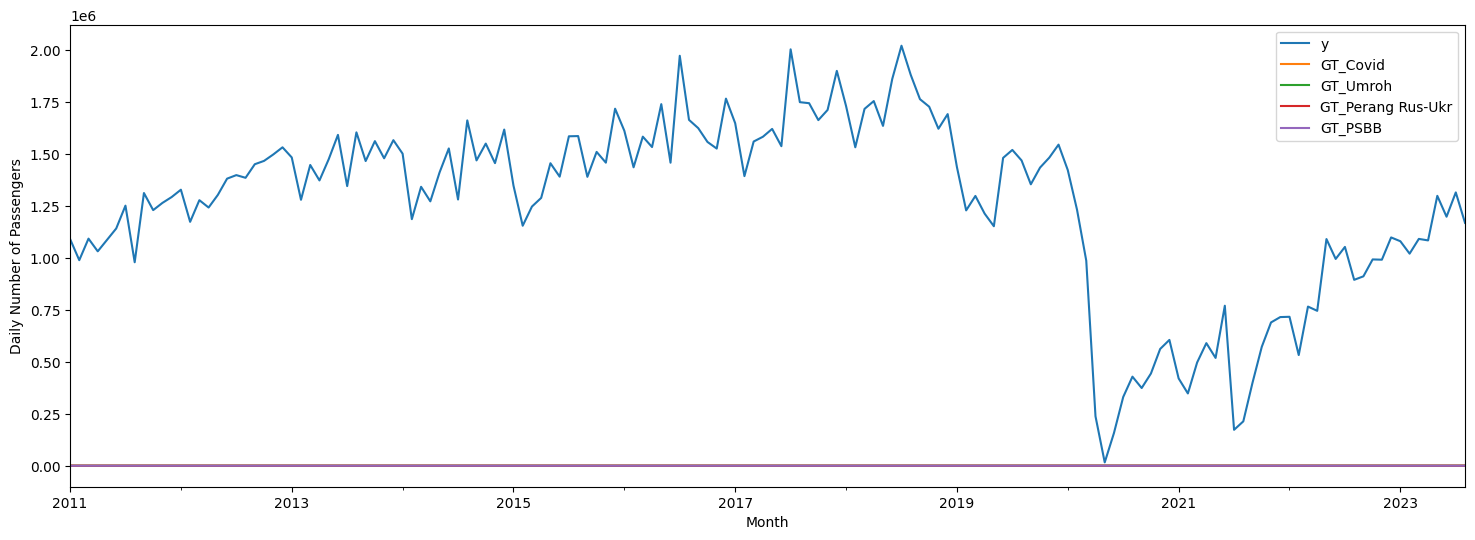

In [ ]:
ax = df.set_index('date').plot(figsize=(18, 6))
ax.set_ylabel('Daily Number of Passengers')
ax.set_xlabel('Month')

plt.show()

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">2. Data Preprocessing ⚙️</p>

<a id='2.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">2.3 Stationarity</p>

Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

* constant mean and mean is not time-dependent
* constant variance and variance is not time-dependent
* constant covariance and covariance is not time-dependent

![stationarity.png](attachment:stationarity.png)

The check for stationarity can be done via three different approaches:

1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Augmented Dickey Fuller test

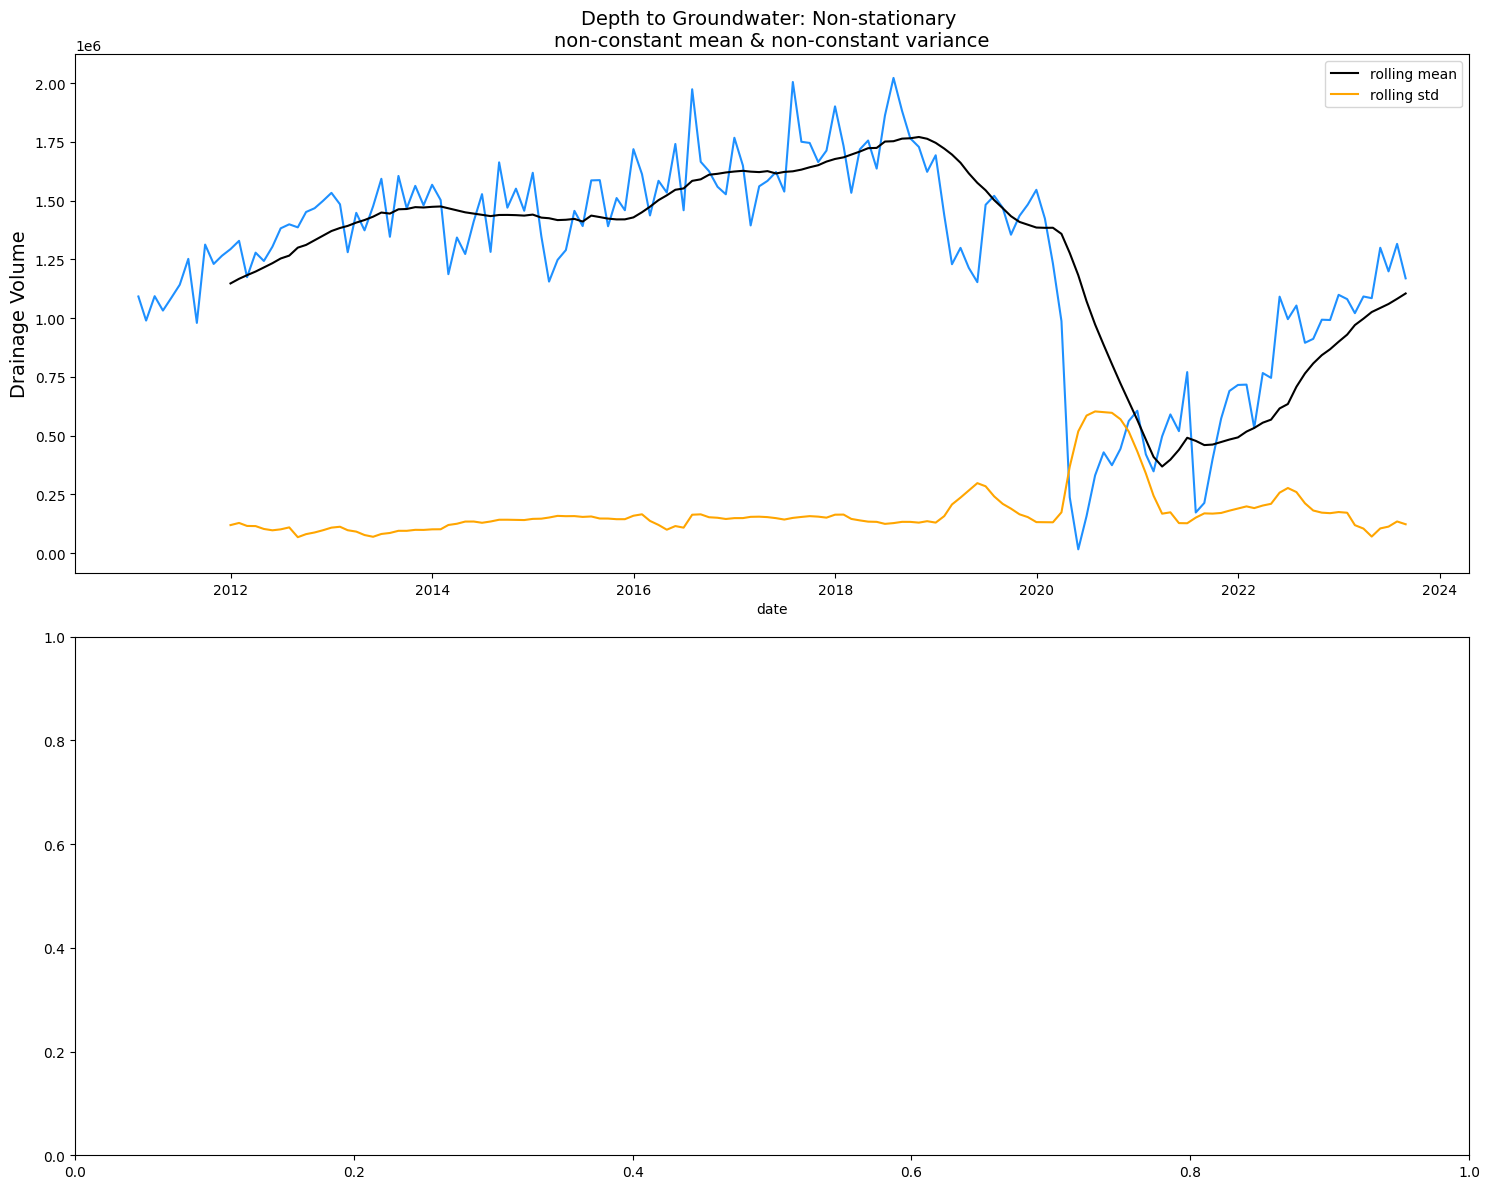

In [ ]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 12
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['y'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['y'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['y'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
#ax[0].set_xlim([date(2011, 1), date(2023, 8)])

plt.tight_layout()
plt.show()

In this **visual check**, we can see that the **features don't have constant mean and std**, but they are close to it.

<a id='2.3.1'></a>
### Unit Root Test

Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.

$Y_t = 	\alpha Y_{t-1} + 	\beta X_{e} + \epsilon $

where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

**The presence of a unit root means the time series is non-stationary.**

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">2.3.1 Augmented Dickey-Fuller (ADF)</p>


**Augmented Dickey-Fuller (ADF)** test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

* **Null Hypothesis (H0)**: Time series has a unit root. (Time series is not stationary).

* **Alternate Hypothesis (H1)**: Time series has no unit root (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* <font color='red'>**p-value > significance level (default: 0.05)**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**p-value <= significance level (default: 0.05)**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.
    
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.
* <font color='red'>**ADF statistic > critical value**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**ADF statistic < critical value**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.

In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['y'].values)
result

(-1.6525099427548315,
 0.4557317459557574,
 12,
 139,
 {'1%': -3.4782936965183815,
  '5%': -2.882567574015525,
  '10%': -2.5779830117488745},
 3673.34747020495)

Now, we are going to check for each variable:
* The p-value is less than 0.05
* Check the range of the ADF statistic compared with critical_values

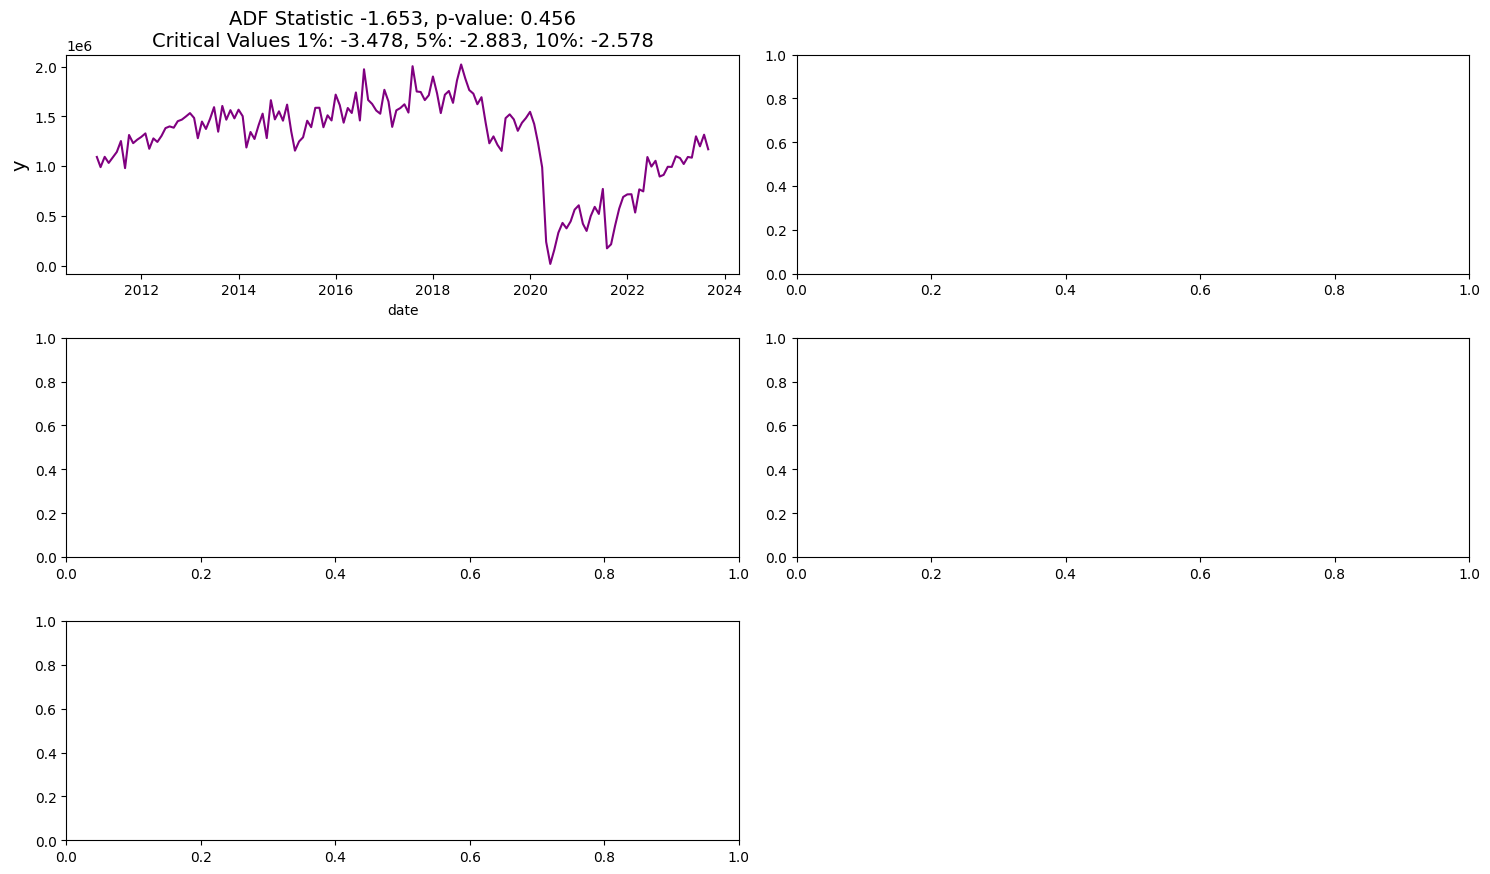

In [ ]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['y'].values, 'y', ax[0, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

* **Transformation**: e.g. log or square root to stabilize non-constant variance
* **Differencing**: subtracts the current value from the previous

<a id='2.3.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">2.3.2 Transforming</p>

<Axes: xlabel='y', ylabel='Density'>

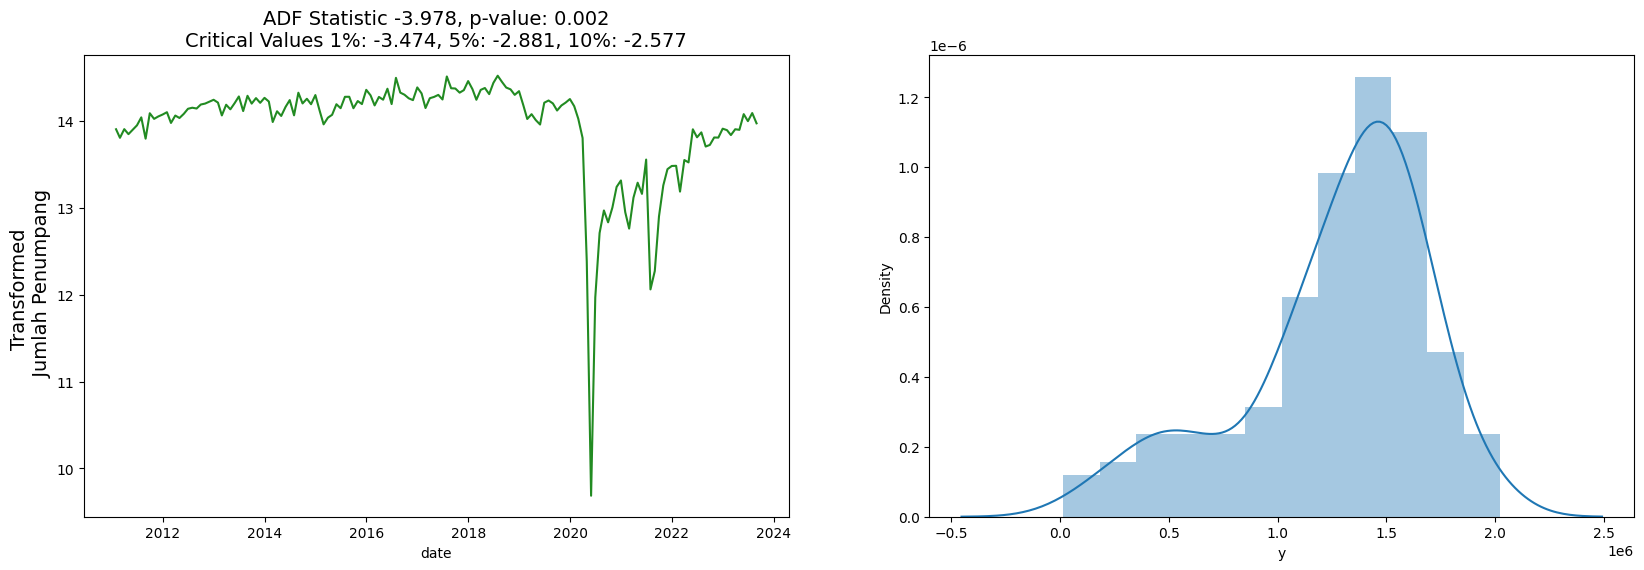

In [ ]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['y_log'] = np.log(abs(df['y']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['y_log'], 'Transformed \n Jumlah Penumpang', ax[0])

sns.distplot(df['y'], ax=ax[1])

Differencing can be done in different orders:
* First order differencing: linear trends with $z_i = y_i - y_{i-1}$
* Second-order differencing: quadratic trends with $z_i = (y_i - y_{i-1}) - (y_{i-1} - y_{i-2})$
* and so on...

<a id='2.3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">2.3.3 Differencing</p>

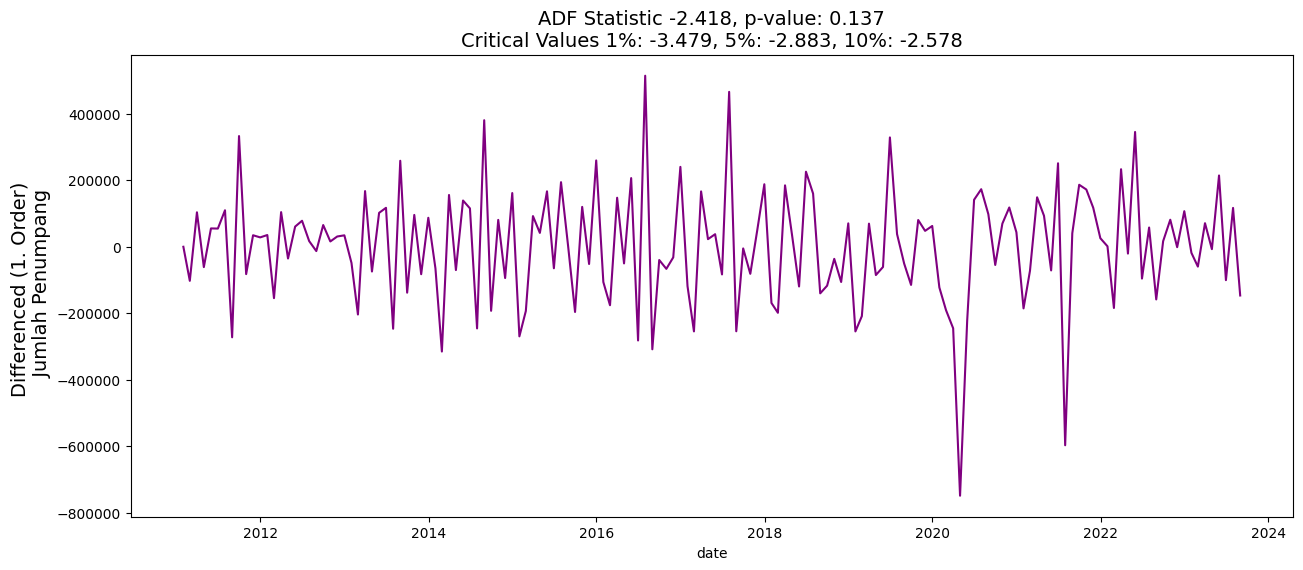

In [ ]:
# First Order Differencing
ts_diff = np.diff(df['y'])
df['y_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['y_diff_1'], 'Differenced (1. Order) \n Jumlah Penumpang', ax)

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">3. Feature engineering 🔧</p>

In [ ]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2011-01-31,2011,1,31,31,5,1,1
1,2011-02-28,2011,2,28,59,9,1,1
2,2011-03-31,2011,3,31,90,13,1,2
3,2011-04-30,2011,4,30,120,17,2,2
4,2011-05-31,2011,5,31,151,22,2,2


<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.1 Encoding Cyclical Features</p>

The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the `month` feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

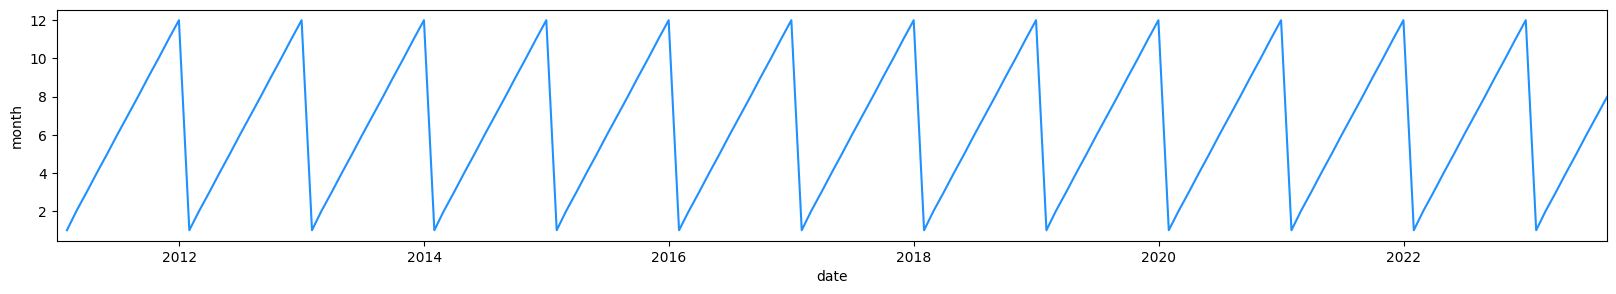

In [ ]:
from datetime import datetime, date
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2011, 1, 1), date(2023, 8, 30)])
plt.show()

Lets encode this cyclical feature:

![cyclical-features.gif](attachment:cyclical-features.gif)

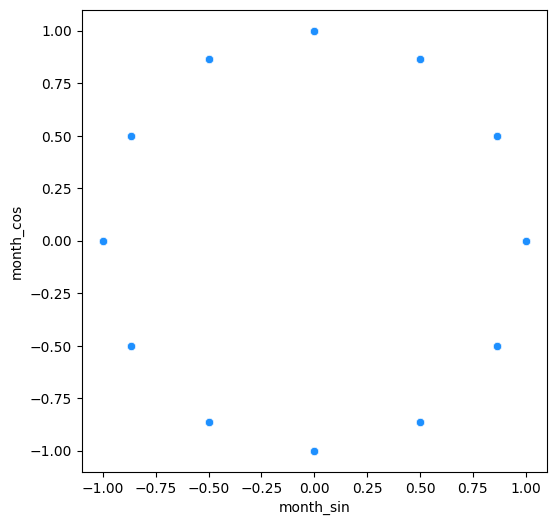

In [ ]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

<a id='3.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.2 TimeSeries Decomposition</p>

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:
* **Additive**: $y(t) = Level + Trend + Seasonality + Noise$
* **Multiplicative**: $y(t) = Level * Trend * Seasonality * Noise$

In this case we are going to use function seasonal_decompose() from the [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) library.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  ['y','GT_PSBB']

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

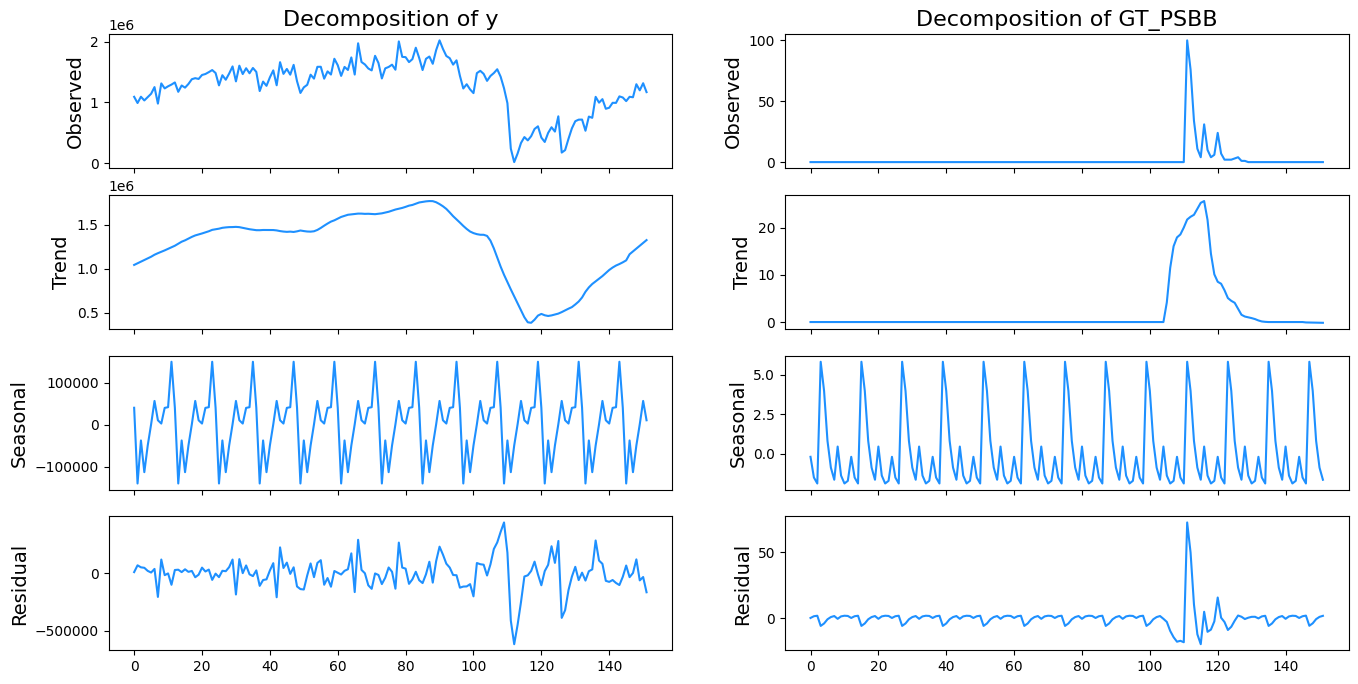

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['y','GT_PSBB']):

    res = seasonal_decompose(df[column], period=12, model='additive', extrapolate_trend=12)

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

<a id='3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.3 Lag</p>


We want to calculate each variable with a `shift()` (lag) to compare the correlationwith the other variables.

You can see [documentation of shift function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) for more information.

In [ ]:
month_in_year = 12

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * month_in_year)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * month_in_year)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * month_in_year)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * month_in_year)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * month_in_year)

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">4. Exploratory Data Analysis 📊</p>

Now, we are going to plot the data and try to extract some knowledge.

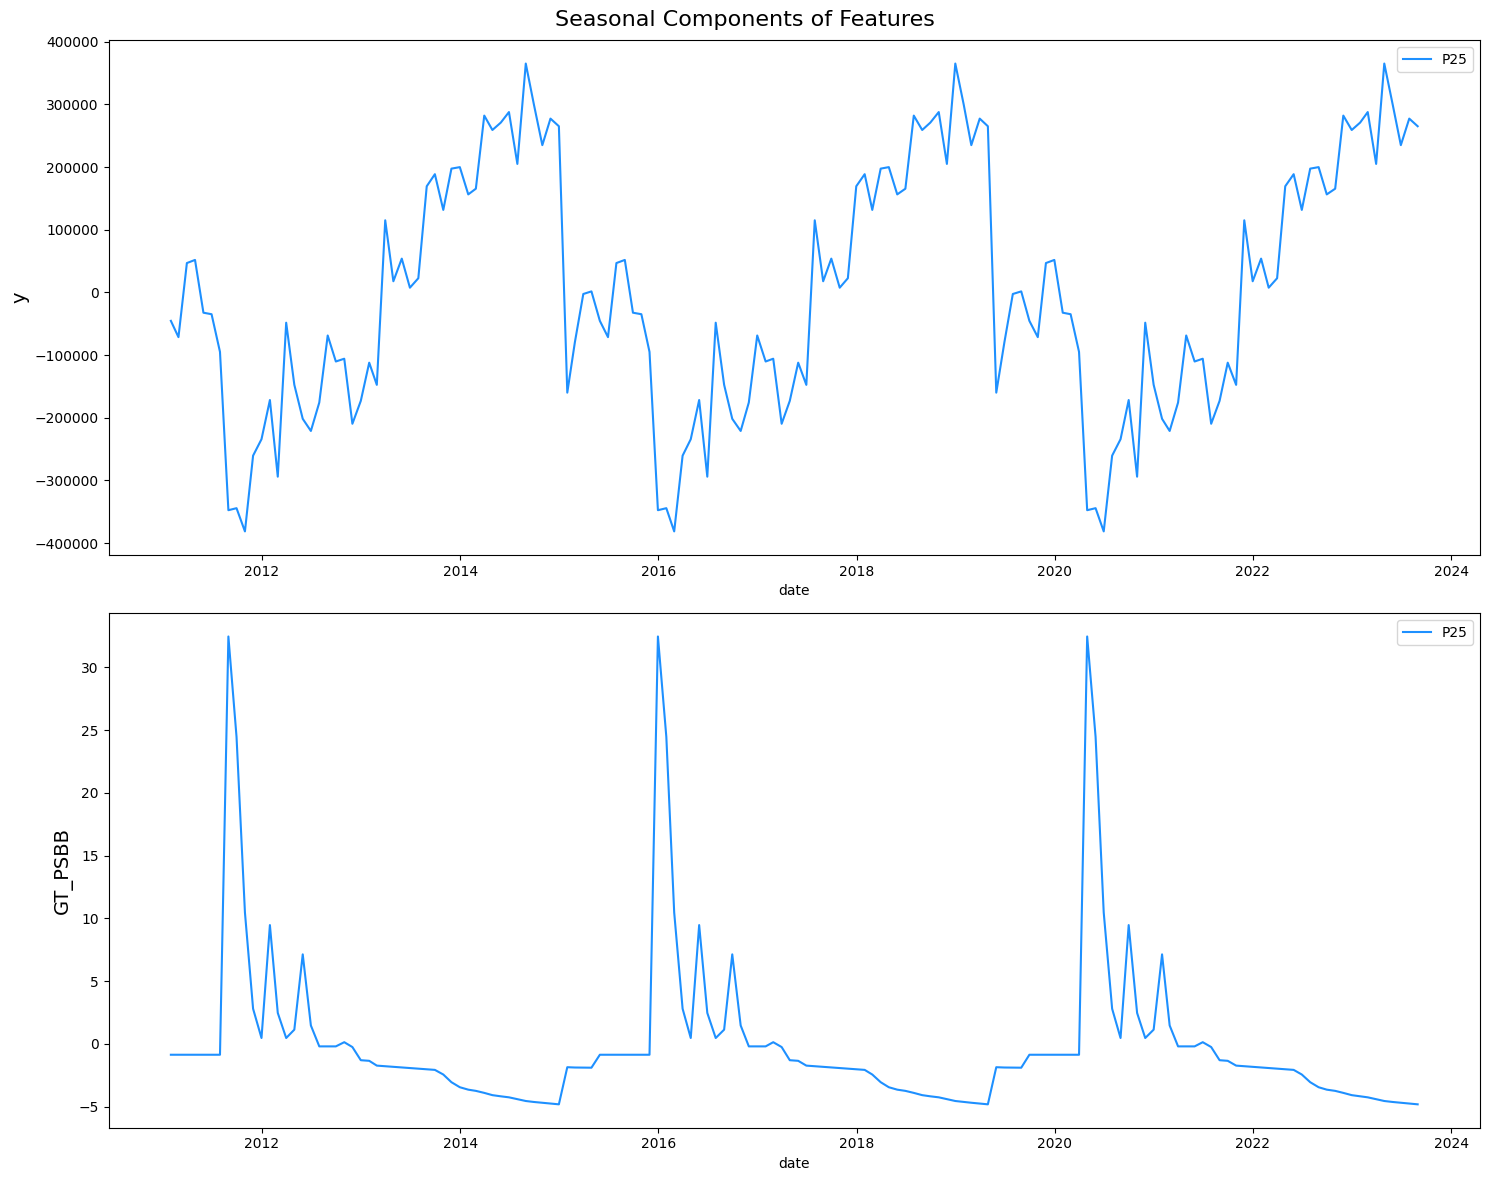

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
  # ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

As we can see:
* **depth_to_groundwater**: reaches its maximum around May/June and its minimum around November
* **temperature**: reaches its maxmium around August and its minimum around January
* **drainage_volume**: reaches its minimum around July.
* **river_hydrometry**: reaches its maximum around February/March and its minimum around September

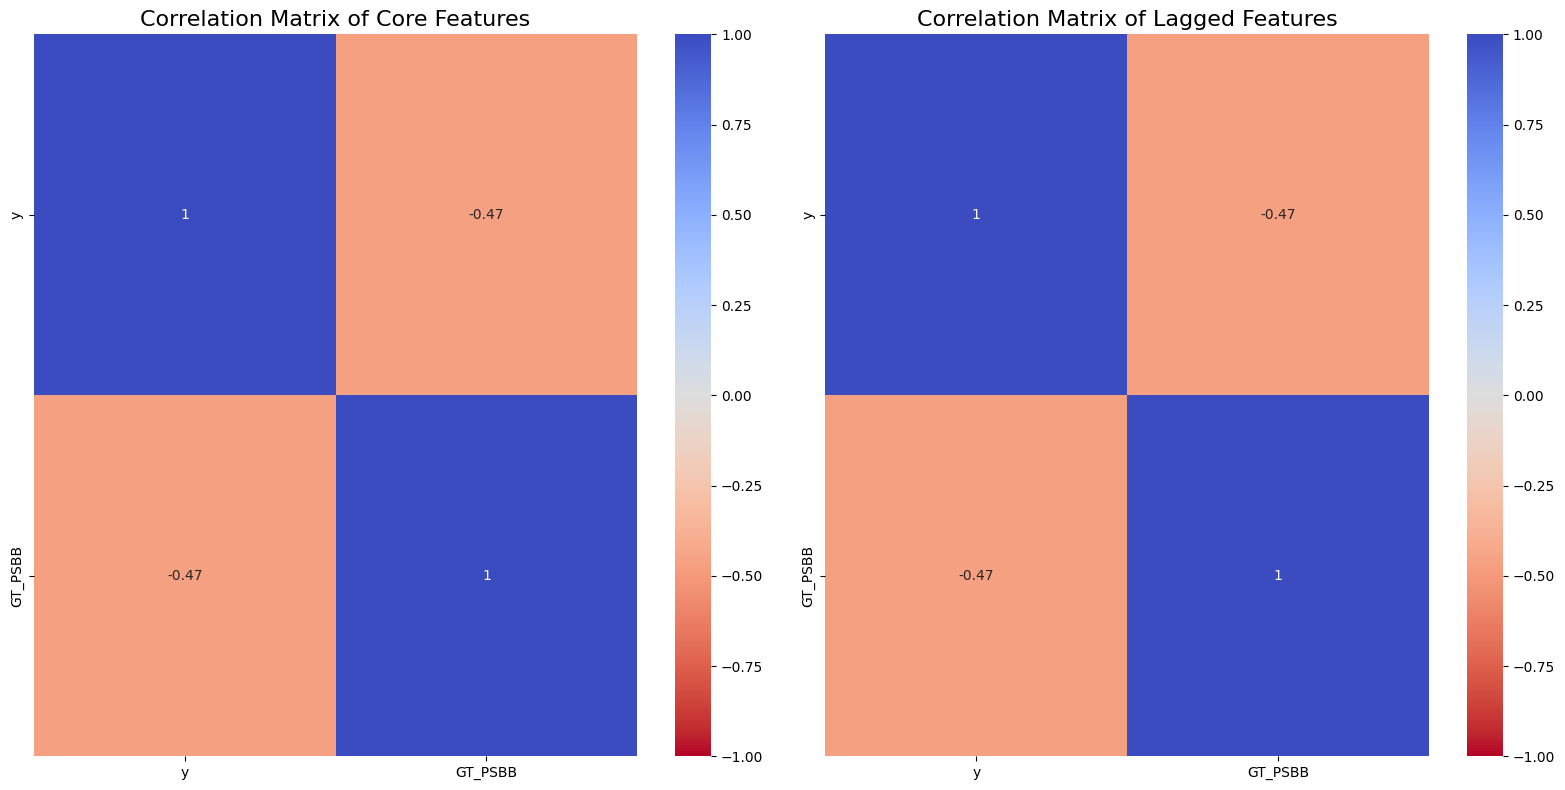

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'y',
    'GT_PSBB',
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

As we can see, the features are higher correlated in the case of shifted features (lagged ones) than the original ones.

<a id='4.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">4.1 Autocorrelation Analysis</p>

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)** plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

* **Autocorrelation Function (ACF)**: P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
* **Partial Autocorrelation Function (PACF)**: D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality.

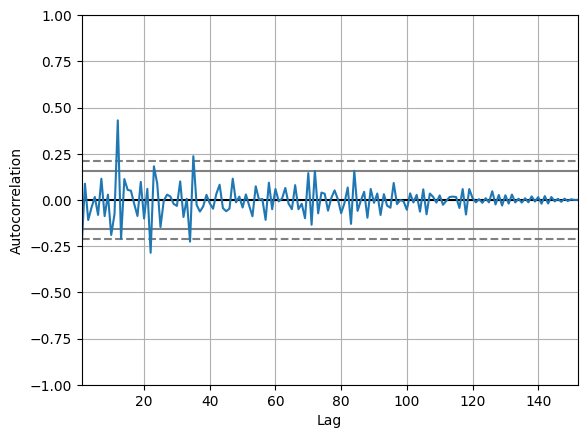

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['y_diff_1'])
plt.show()

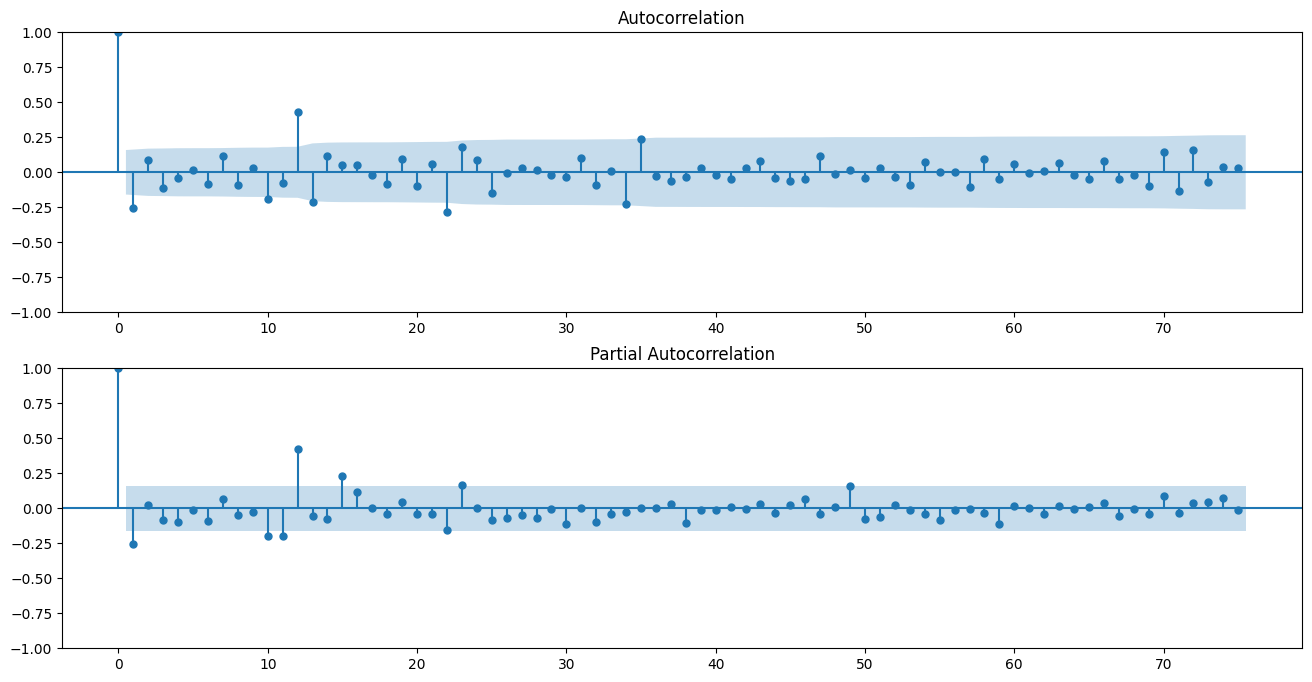

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['y_diff_1'], lags=75, ax=ax[0])
plot_pacf(df['y_diff_1'], lags=75, ax=ax[1])

plt.show()

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">5. Modeling 🧩</p>

Time series can be either univariate or multivariate:

* **Univariate** time series only has a single time-dependent variable.
* **Multivariate** time series have a multiple time-dependent variable.

But, first of all we are going to see how does cross-validation technic works in TimeSeries Analysis.

In [ ]:
df.head()

,date,y,GT_Covid,GT_Umroh,GT_Perang Rus-Ukr,GT_PSBB,y_log,y_diff_1,y_trend,y_seasonal,...,season,month_sin,month_cos,GT_PSBB_trend,GT_PSBB_seasonal,GT_PSBB_seasonal_shift_b_2m,GT_PSBB_seasonal_shift_b_1m,GT_PSBB_seasonal_shift_1m,GT_PSBB_seasonal_shift_2m,GT_PSBB_seasonal_shift_3m
0,2011-01-31,1092145.0,0,23,0,0,13.903654,0.0,1.248410e+06,-45332.422196,...,1,0.500000,8.660254e-01,0.0,-0.866021,-1.350129,9.467312,NaN,NaN,NaN
1,2011-02-28,989675.0,0,21,0,0,13.805132,-102470.0,1.253418e+06,-71345.774678,...,1,0.866025,5.000000e-01,0.0,-0.866021,-1.732075,2.467312,NaN,NaN,NaN
2,2011-03-31,1093419.0,0,25,0,0,13.904820,103744.0,1.258426e+06,46885.485021,...,2,1.000000,6.123234e-17,0.0,-0.866021,-1.780687,0.467312,NaN,NaN,NaN
3,2011-04-30,1032268.0,0,26,1,0,13.847269,-61151.0,1.263434e+06,51877.382539,...,2,0.866025,-5.000000e-01,0.0,-0.866021,-1.829299,1.133979,NaN,NaN,NaN
4,2011-05-31,1087500.0,0,24,0,0,13.899392,55232.0,1.268442e+06,-32353.325712,...,2,0.500000,-8.660254e-01,0.0,-0.866021,-1.877911,7.133979,NaN,NaN,NaN


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['y']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

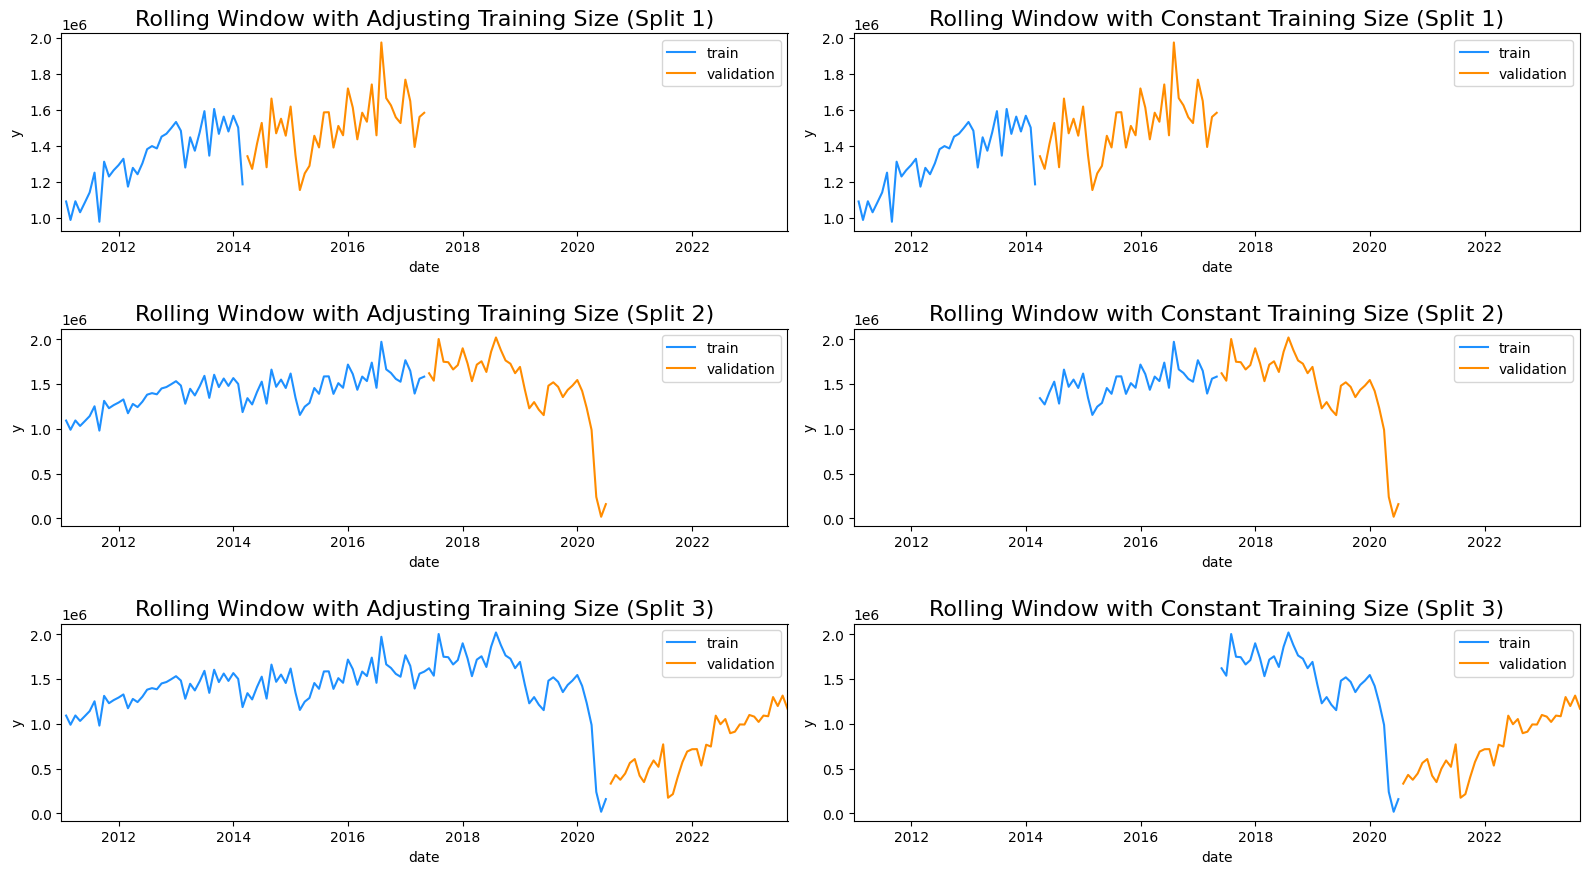

In [ ]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train,
        y=y_train,
        ax=ax[i,0],
        color='dodgerblue',
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        ax=ax[i,1],
        color='dodgerblue',
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2011, 1, 1), date(2023, 8, 31)])
    ax[i, 1].set_xlim([date(2011, 1, 1), date(2023, 8, 31)])

plt.tight_layout()
plt.show()

The idea with this plot is to understand which train and test set are we using to fit the model in each iteration.

<a id='5.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">5.1 Models for Univariate Time Series</p>

First of all, we are going to analize univariate TimeSeries forecasting.

**Univariate time series**: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [ ]:
df

,y,y_log,y_diff_1,y_trend,y_seasonal,y_seasonal_shift_b_2m,y_seasonal_shift_b_1m,y_seasonal_shift_1m,y_seasonal_shift_2m,y_seasonal_shift_3m
date,,,,,,,,,,
2011-01-31,1092145.0,13.903654,0.0,1.248410e+06,-45332.422196,-112108.617370,-171742.248127,NaN,NaN,NaN
2011-02-28,989675.0,13.805132,-102470.0,1.253418e+06,-71345.774678,-147510.298176,-294039.401891,NaN,NaN,NaN
2011-03-31,1093419.0,13.904820,103744.0,1.258426e+06,46885.485021,115133.525961,-48303.722321,NaN,NaN,NaN
2011-04-30,1032268.0,13.847269,-61151.0,1.263434e+06,51877.382539,17819.354688,-147397.395315,NaN,NaN,NaN
2011-05-31,1087500.0,13.899392,55232.0,1.268442e+06,-32353.325712,53956.907774,-201688.004207,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-04-30,1084894.0,13.896993,-7239.0,3.871425e+05,365277.223293,NaN,NaN,169451.836262,-68698.834087,-347535.117130
2023-05-31,1299488.0,14.077481,214594.0,3.692424e+05,299800.824456,NaN,NaN,188716.991912,-110209.023107,-344317.427945
2023-06-30,1198978.0,13.996980,-100510.0,3.513423e+05,235069.864721,NaN,NaN,131692.176409,-105788.096743,-381392.165042


In [ ]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date','y']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

121 31


<a id='5.1.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.1 Prophet</p>

The first model (which also can handle multivariate problems) we are going to try is Facebook Prophet.

Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math

from prophet import Prophet


# Train the model
model = Prophet(seasonality_mode='multiplicative')
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_mape = mean_absolute_percentage_error(y_valid, y_pred.tail(test_size)['yhat'])


print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.GREEN + 'MAPE: {}'.format(score_mape*100))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo4z_w00n/d0kuge6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo4z_w00n/zn4_ad35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92495', 'data', 'file=/tmp/tmpo4z_w00n/d0kuge6h.json', 'init=/tmp/tmpo4z_w00n/zn4_ad35.json', 'output', 'file=/tmp/tmpo4z_w00n/prophet_modelzr_7h7w7/prophet_model-20231104093749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:37:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 939868.9478348722
MAPE: 86.29793742368481


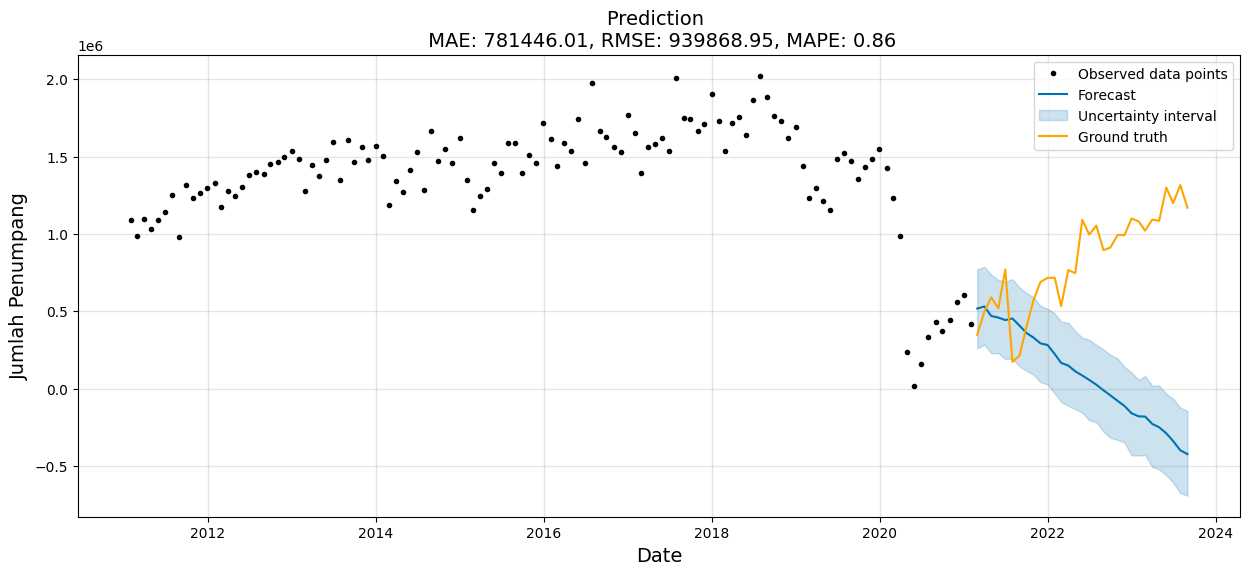

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}, MAPE: {score_mape:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Jumlah Penumpang', fontsize=14)

plt.show()

<a id='5.1.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.2 ARIMA</p>

The second model that i want to try is ARIMA.

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the **autocorrelations** in the data. The model assumes that the time-series is **stationary**. It consists of three main parts:
* <font color='purple'>Auto-Regressive (AR) filter (long term)</font>:
    
    $\color{purple}{y_t = c + \alpha_1 y_{t-1} + \dots \alpha_{\color{purple}p}y_{t-\color{purple}p} + \epsilon_t = c + \sum_{i=1}^p{\alpha_i}y_{t-i} + \epsilon_t}$  -> p
* <font color='orange'> Integration filter (stochastic trend)</font>
    
    -> d
* <font color='blue'>Moving Average (MA) filter (short term)</font>:

    $\color{blue}{y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q} = c + \epsilon_t + \sum_{i=1}^q{\beta_i}\epsilon_{t-i}} $  -> q


**ARIMA**: $y_t = c + \color{purple}{\alpha_1 y_{t-1} + \dots + \alpha_{\color{purple}p}y_{t-\color{purple}p}} + \color{blue}{\epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q}}$


ARIMA(
<font color='purple'>p</font>,
<font color='orange'>d</font>,
<font color='blue'>q</font>)

* <font color='purple'>p</font>: Lag order (reference  PACF in [Autocorrelation Analysis](#4.1-Autocorrelation-Analysis))
* <font color='orange'>d</font>: Degree of differencing. (reference  Differencing in [Stationarity](#2.3-Stationarity))
* <font color='blue'>q</font>: Order of moving average (check out ACF in [Autocorrelation Analysis](#4.1-Autocorrelation-Analysis))

### Steps to analyze ARIMA

* **Step 1 — Check stationarity**: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. .
* **Step 2 — Difference**: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
* **Step 3 — Filter out a validation sample**: This will be used to validate how accurate our model is. Use train test validation split to achieve this
* **Step 4 — Select AR and MA terms**: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
* **Step 5 — Build the model**: Build the model and set the number of periods to forecast to N (depends on your needs).
* **Step 6 — Validate model**: Compare the predicted values to the actuals in the validation sample.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,1,0))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.predict(1,31)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))
score_mape = mean_absolute_percentage_error(y_valid, y_pred)

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.GREEN + 'MAPE: {}'.format(score_mape))

RMSE: 507505.0053431337
MAPE: 0.9055374242249177


In [ ]:
y_pred

1     8.661199e+05
2     1.010882e+06
3     1.071948e+06
4     1.044924e+06
5     1.076069e+06
6     1.130943e+06
7     1.229452e+06
8     1.036104e+06
9     1.243999e+06
10    1.247718e+06
11    1.258198e+06
12    1.287765e+06
13    1.321638e+06
14    1.206333e+06
15    1.257008e+06
16    1.250522e+06
17    1.291381e+06
18    1.366005e+06
19    1.395731e+06
20    1.388992e+06
21    1.438169e+06
22    1.464386e+06
23    1.492247e+06
24    1.525943e+06
25    1.494411e+06
26    1.322653e+06
27    1.413373e+06
28    1.389037e+06
29    1.454590e+06
30    1.568705e+06
31    1.397325e+06
Name: predicted_mean, dtype: float64

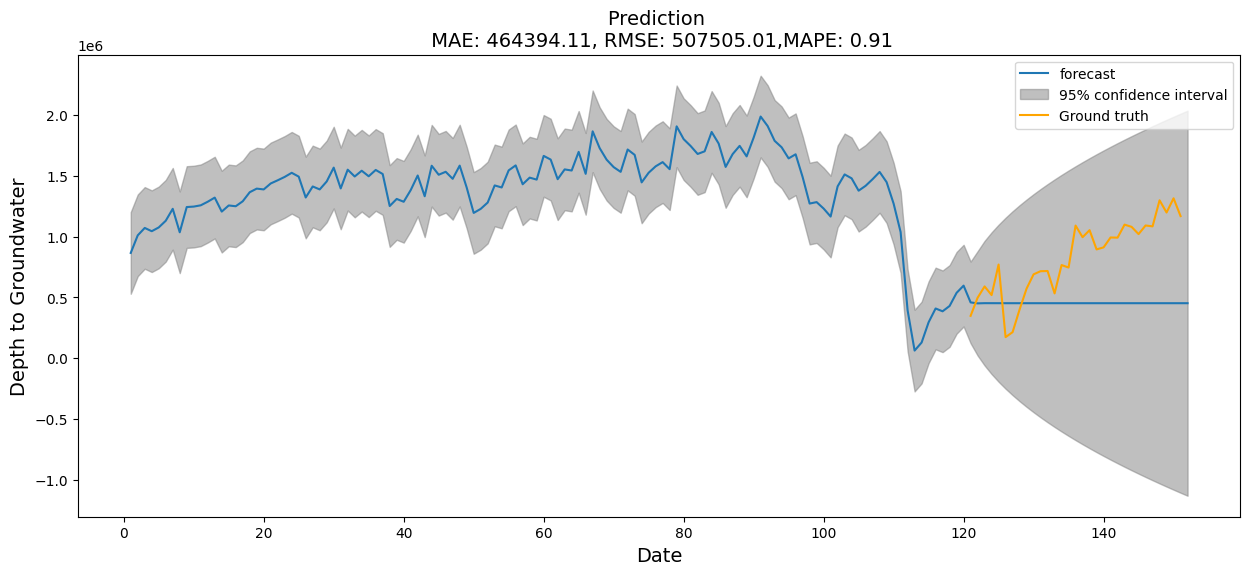

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict

f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

plot_predict(model_fit, start=1, end=152, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f},MAPE: {score_mape:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
#ax.set_ylim(-35, -18)
plt.show()

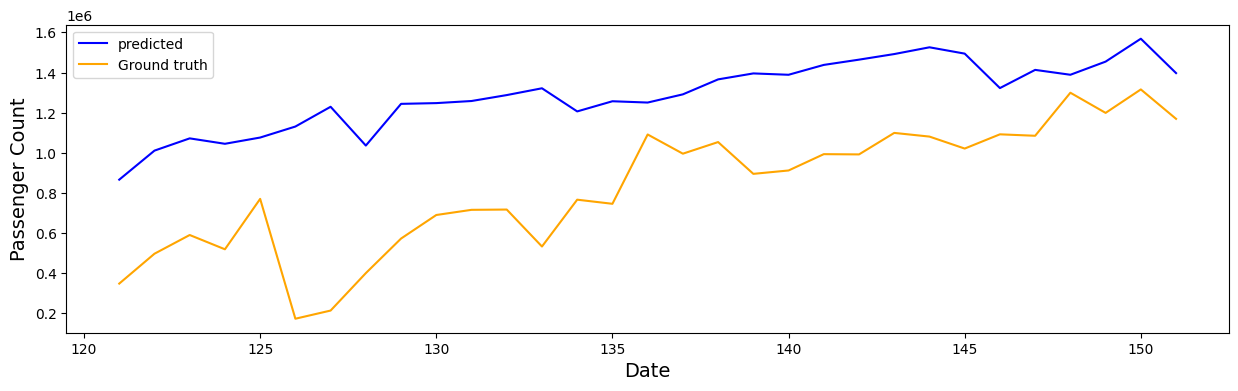

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Passenger Count', fontsize=14)

plt.show()

<a id='5.1.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.3 Auto-ARIMA</p>

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.9 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3054.735, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3058.348, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3052.982, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3053.987, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3056.593, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3054.684, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3056.713, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3051.226, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3052.920, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3052.989, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3052.143, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3054.954, Time=0.26 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.360 seconds
                               SARIMAX Results                                
Dep. Vari

As we saw in the previous Steps, AutoARIMA (auto_arima) validates that (1,1,1) is the best configuration for (p,d,q).

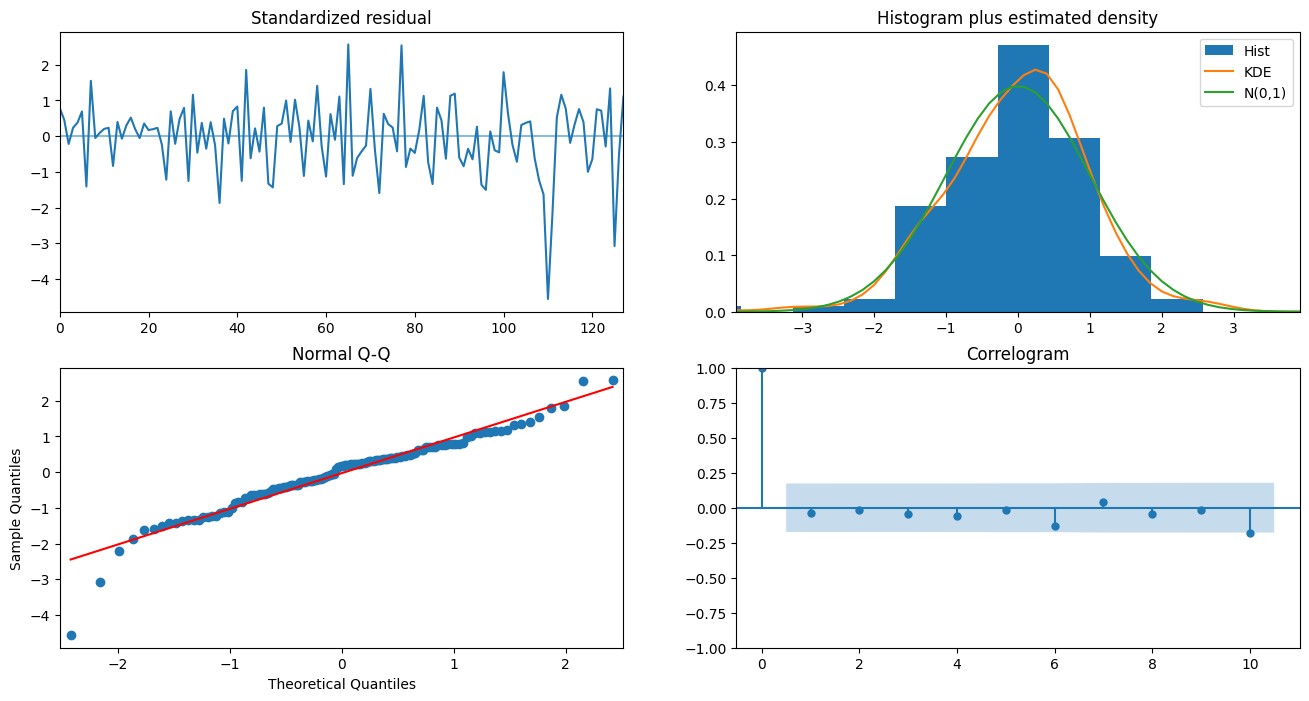

In [ ]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

So how to interpret the plot diagnostics?

* **Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-4, 4).

* **Top Right**: The density plot suggest normal distribution with mean zero.

* **Bottom left**: The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

* **Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

<a id='5.1.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.4 LSTM</p>

We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

The following data pre-processing and feature engineering need to be done before construct the LSTM model.
* Create the dataset, ensure all data is float.
* Normalize the features.
* Split into training and test sets.
* Convert an array of values into a dataset matrix.
* Reshape into X=t and Y=t+1.
* Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.46362857],
       [-0.51470549],
       [-0.46299354],
       [-0.4934747 ],
       [-0.4659439 ],
       [-0.43863841],
       [-0.38384749],
       [-0.51967361],
       [-0.35355574],
       [-0.3945708 ]])

In [ ]:
# Defines the rolling window
look_back = 2
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

117 31


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=20, validation_data=(x_test, y_test))

model.summary()

Epoch 1/20
117/117 [==============================] - 3s 8ms/step - loss: 0.0290 - val_loss: 0.0327
Epoch 2/20
117/117 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0084
Epoch 3/20
117/117 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0180
Epoch 4/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0114
Epoch 5/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0106
Epoch 6/20
117/117 [==============================] - 1s 6ms/step - loss: 0.0105 - val_loss: 0.0072
Epoch 7/20
117/117 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0196
Epoch 8/20
117/117 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0441
Epoch 9/20
117/117 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0063
Epoch 10/20
117/117 [==============================] - 0s 3ms/step - loss: 0.0088 - val_loss: 0.0098

In [ ]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.GREEN + 'MAPE: {}'.format(score_mape))


1/1 [==============================] - 0s 16ms/step
RMSE: 159729.1339919963
MAPE: 0.26081932469657226


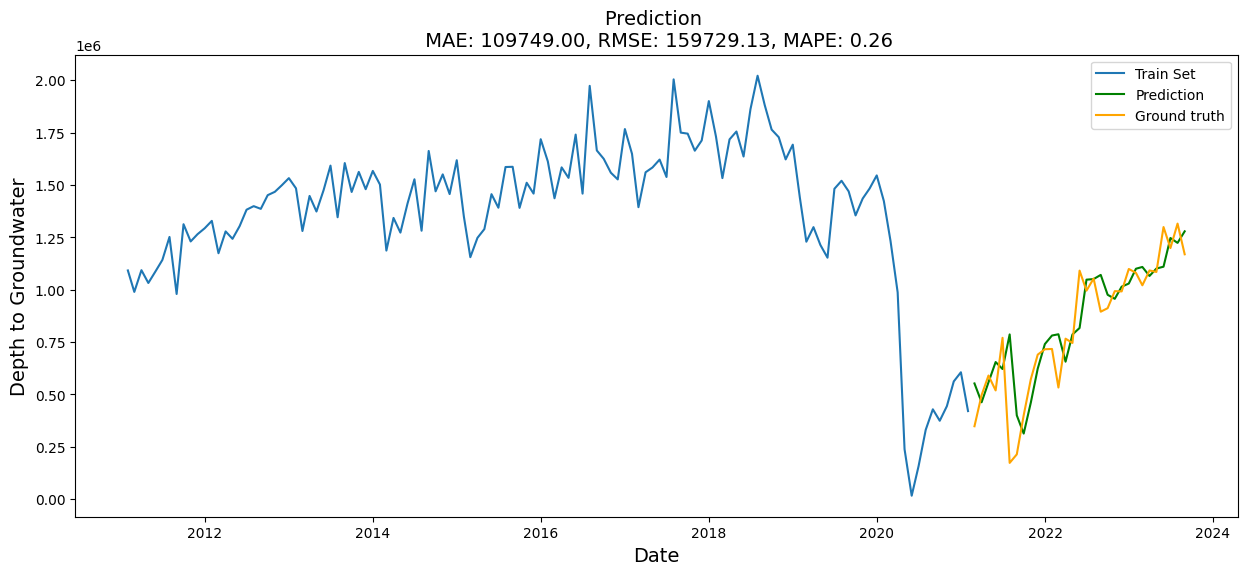

In [ ]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}, MAPE: {score_mape:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

<a id='5.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">5.2 Models for Multivariate Time Series</p>

Finnally, we are going to analize multivariate TimeSeries forecasting.

**Multivariate time series:** Multiple variables are varying over time. For example, a tri-axial accelerometer. There are three accelerations, one for each axis (x,y,z) and they vary simultaneously over time.

In [ ]:
df

,date,y,GT_Covid,GT_Umroh,GT_Perang Rus-Ukr,GT_PSBB,y_log,y_diff_1,y_trend,y_seasonal,y_seasonal_shift_b_2m,y_seasonal_shift_b_1m,y_seasonal_shift_1m,y_seasonal_shift_2m,y_seasonal_shift_3m
0,2011-01-31,1092145.0,0,23,0,0,13.903654,0.0,1.248410e+06,-45332.422196,-112108.617370,-171742.248127,NaN,NaN,NaN
1,2011-02-28,989675.0,0,21,0,0,13.805132,-102470.0,1.253418e+06,-71345.774678,-147510.298176,-294039.401891,NaN,NaN,NaN
2,2011-03-31,1093419.0,0,25,0,0,13.904820,103744.0,1.258426e+06,46885.485021,115133.525961,-48303.722321,NaN,NaN,NaN
3,2011-04-30,1032268.0,0,26,1,0,13.847269,-61151.0,1.263434e+06,51877.382539,17819.354688,-147397.395315,NaN,NaN,NaN
4,2011-05-31,1087500.0,0,24,0,0,13.899392,55232.0,1.268442e+06,-32353.325712,53956.907774,-201688.004207,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,2023-04-30,1084894.0,3,47,39,0,13.896993,-7239.0,3.871425e+05,365277.223293,NaN,NaN,169451.836262,-68698.834087,-347535.117130
148,2023-05-31,1299488.0,3,62,36,0,14.077481,214594.0,3.692424e+05,299800.824456,NaN,NaN,188716.991912,-110209.023107,-344317.427945
149,2023-06-30,1198978.0,2,46,38,0,13.996980,-100510.0,3.513423e+05,235069.864721,NaN,NaN,131692.176409,-105788.096743,-381392.165042
150,2023-07-31,1315956.0,1,40,41,0,14.090074,116978.0,3.334422e+05,277412.033192,NaN,NaN,197591.998725,-209607.637168,-260486.338036


In [ ]:
feature_columns = [
    'GT_Covid',
    'GT_Umroh',
    'GT_Perang Rus-Ukr',
    'GT_PSBB',
]
target_column = ['y']

train_size = int(0.8 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,GT_Covid,GT_Umroh,GT_Perang Rus-Ukr,GT_PSBB
0,2011-01-31,1092145.0,0,23,0,0
1,2011-02-28,989675.0,0,21,0,0
2,2011-03-31,1093419.0,0,25,0,0
3,2011-04-30,1032268.0,0,26,1,0
4,2011-05-31,1087500.0,0,24,0,0


<a id='5.2.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.2.1 Multivariate Prophet</p>

In [ ]:
from prophet import Prophet

# Train the model
model = Prophet(seasonality_mode='multiplicative')
model.add_regressor('GT_Covid')
model.add_regressor('GT_Umroh')
#model.add_regressor('GT_Perang Rus-Ukr')
#model.add_regressor('GT_PSBB')
model.add_country_holidays('ID')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))
score_mape = mean_absolute_percentage_error(y_valid, y_pred['yhat'])

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

print(Fore.GREEN + 'MAPE: {}'.format(score_mape*100))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo4z_w00n/68s_qms6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo4z_w00n/lpdt_0kg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40596', 'data', 'file=/tmp/tmpo4z_w00n/68s_qms6.json', 'init=/tmp/tmpo4z_w00n/lpdt_0kg.json', 'output', 'file=/tmp/tmpo4z_w00n/prophet_modelz588_sdr/prophet_model-20231104101158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:11:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:11:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 363305.9953675818
MAPE: 36.87417976753805


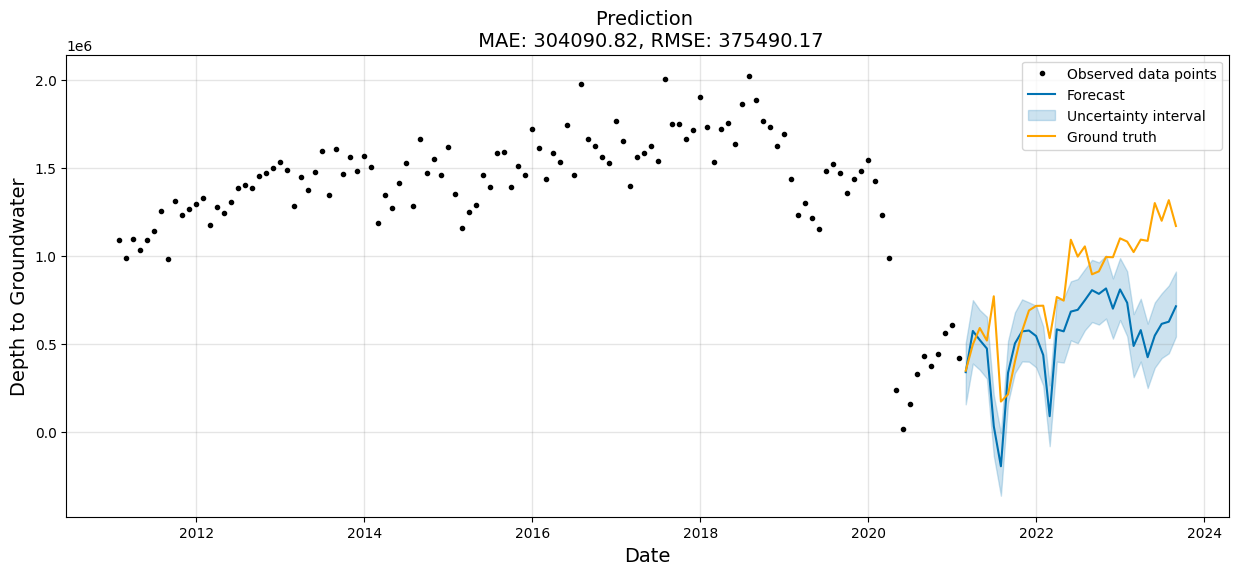

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

# LSTM Multivariate

In [ ]:
multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler


<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">6. Conclusions 💎</p>

The best results are taken from Univariate LSTM (with rolling window of 1 year) and multi-variate Prophet.

<a id='7'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">7. References 📝</p>

Here I am going to reference some useful links that I have used to build this notebook
* Special reference for the helpful information and plots - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting
* ARIMA - https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06
* Auto-ARIMA - https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
* Keras LSTM - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* Prophet - https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236
* Special reference - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting/notebook#Models
* Cyclical features - https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
* ADF - https://medium.com/@cmukesh8688/why-is-augmented-dickey-fuller-test-adf-test-so-important-in-time-series-analysis-6fc97c6be2f0
* ACF/PACF - https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
* LSTM - https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba